In [4]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [5]:
!ls -ltr
!hostname -i

total 167000
-rw-r--r-- 1 jd jd 170498071 Sep 12 19:54 cifar-10-python.tar.gz
drwxr-xr-x 2 jd jd      4096 Sep 19 21:33 data
drwxrwxr-x 2 jd jd      4096 Sep 23 13:03 gradcam
drwxrwxr-x 2 jd jd      4096 Sep 23 17:28 image
drwxrwxr-x 4 jd jd      4096 Sep 23 21:33 model_file
drwxr-xr-x 2 jd jd      4096 Sep 23 22:06 cifar-10-batches-py
drwxrwxr-x 2 jd jd      4096 Sep 23 22:06 __pycache__
-rw-rw-r-- 1 jd jd     43589 Sep 24 00:46 model_history.png
-rw-rw-r-- 1 jd jd    151713 Sep 24 00:47 Test_missclassified_images.jpg
drwxrwxr-x 4 jd jd      4096 Sep 24 11:53 model_utility
-rwxr-xr-x 1 jd jd    267910 Sep 24 11:57 EVA5_session_9.ipynb
drwxrwxr-x 3 jd jd      4096 Sep 24 11:57 data_augmentation
127.0.1.1


# Loading UD modules

In [6]:
from __future__ import print_function
import torch
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from torchsummary import summary
from tqdm import tqdm
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import os 
import numpy as np


import model_utility.data_utils as dutils
import model_utility.model_utils as mutils
import model_utility.plot_utils as putils 
import model_utility.regularization as regularization
import model_file.model_cifar as model_cifar
import model_utility.alb_utils as alb

import model_file.models as mod

import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
import data_augmentation.albumentations as A
from data_augmentation.albumentations.pytorch import ToTensor

In [8]:
A.__version__
A.__file__
A.Compose.__module__
A.Cutout.__module__
A.RandomCrop.__module__
A.HorizontalFlip.__module__
A.ElasticTransform.__module__
A.CoarseDropout.__module__
A.Normalize.__module__
A.pytorch.ToTensor.__module__
A.pytorch.ToTensor.__module__

'0.4.6'

'/home/jd/Desktop/EVA5/session9/data_augmentation/albumentations/__init__.py'

'data_augmentation.albumentations.core.composition'

'data_augmentation.albumentations.augmentations.transforms'

'data_augmentation.albumentations.augmentations.transforms'

'data_augmentation.albumentations.augmentations.transforms'

'data_augmentation.albumentations.augmentations.transforms'

'data_augmentation.albumentations.augmentations.transforms'

'data_augmentation.albumentations.augmentations.transforms'

'data_augmentation.albumentations.pytorch.transforms'

'data_augmentation.albumentations.pytorch.transforms'

# Check GPU avaiability

In [6]:
device = dutils.get_device()

CUDA Available? True
Device is cuda:0


In [8]:
cuda = torch.cuda.is_available()
print(cuda)

True

# CIFAR10 Basics

In [10]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

SEED = 1
batch_size=128

# CUDA?
if device.type == 'cuda':
    torch.cuda.manual_seed(SEED)
else:
    torch.manual_seed(SEED)

# Load CIFAR10 dataset

In [11]:
os.getcwd()

'/home/jd/Desktop/EVA5/session9'

In [12]:
path = os.getcwd()
path

'/home/jd/Desktop/EVA5/session9'

In [13]:
batch_size = 128

In [14]:
# load CIFAR10 dataset
train_loader, test_loader = alb.get_dataloader(batch_size=batch_size, num_workers=4, cuda = True,path = path )

Running over Cuda !!  True
Files already downloaded and verified
Files already downloaded and verified
mean 0.49186864
standard dev 0.24697131
mean 0.48265335
standard dev 0.24338901
mean 0.44717798
standard dev 0.26159254
Files already downloaded and verified
Files already downloaded and verified


# Data mage Visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

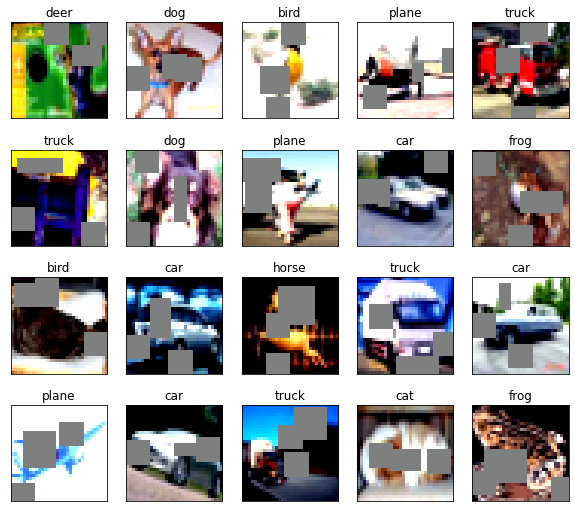

In [15]:
#Plot 20 random images
putils.plot_dataset_images(device, classes, train_loader)

### Model stracture

In [16]:
model = mod.ResNet18()

In [17]:
mutils.model_summary(model, device, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

In [18]:
# Create CIFAR10 network
# model = model_cifar.Net(dropout_value = 0.05)
# mutils.model_summary(model, device, input_size=(3, 32, 32))

# Build and train model

In [19]:
from tqdm import tqdm

In [20]:
# build and train the model
model_name = "Model CIFAR10"
EPOCHS = 10
model =  model.to(device) # use GPU

# using L1 and L2 regularization
train_acc, train_losses, test_acc, test_losses = mutils.build_model(model, 
                                                            device, 
                                                            trainloader=train_loader, 
                                                            testloader=test_loader, 
                                                            epochs=EPOCHS,
                                                            L1_loss_flag=True,
                                                            L2_penalty_val=0.001)

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 0


/home/jd/anaconda3/envs/eva5/lib/python3.8/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.552072, Accuracy: 4202/10000 (42.02%)

EPOCH: 1


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.283136, Accuracy: 5365/10000 (53.65%)

EPOCH: 2


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.108794, Accuracy: 6028/10000 (60.28%)

EPOCH: 3


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.994083, Accuracy: 6586/10000 (65.86%)

EPOCH: 4


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.484349, Accuracy: 5102/10000 (51.02%)

EPOCH: 5


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.951985, Accuracy: 6820/10000 (68.20%)

EPOCH: 6


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.793336, Accuracy: 7287/10000 (72.87%)

EPOCH: 7


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.980089, Accuracy: 6812/10000 (68.12%)

EPOCH: 8


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.453624, Accuracy: 8469/10000 (84.69%)

EPOCH: 9


Loss=0.577655 Batch_id=390 Accuracy=84.74: 100%|██████████| 391/391 [03:39<00:00,  1.79it/s]



Test set: Average loss: 0.424493, Accuracy: 8535/10000 (85.35%)



In [26]:
A.__file__

'/home/jd/anaconda3/envs/eva5/lib/python3.8/site-packages/albumentations/__init__.py'

# Test Accuracy

In [21]:
mutils.get_test_accuracy(model, device, test_loader)


Accuracy of the network on the 10000 test images: 85.35%



### Class level Accuracy

In [22]:

mutils.class_based_accuracy(model, device, classes, test_loader)

Accuracy of plane : 84 %
Accuracy of   car : 96 %
Accuracy of  bird : 71 %
Accuracy of   cat : 74 %
Accuracy of  deer : 78 %
Accuracy of   dog : 76 %
Accuracy of  frog : 85 %
Accuracy of horse : 97 %
Accuracy of  ship : 96 %
Accuracy of truck : 89 %


# Visualization


Ploting Accuracy and Loss history: Model CIFAR10



/home/jd/Desktop/EVA5/session9/model_utility/plot_utils.py:24: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[0].set_xticks(np.arange(1,x_size+1),x_size/10)
/home/jd/Desktop/EVA5/session9/model_utility/plot_utils.py:35: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[1].set_xticks(np.arange(1,x_size+1),x_size/10)


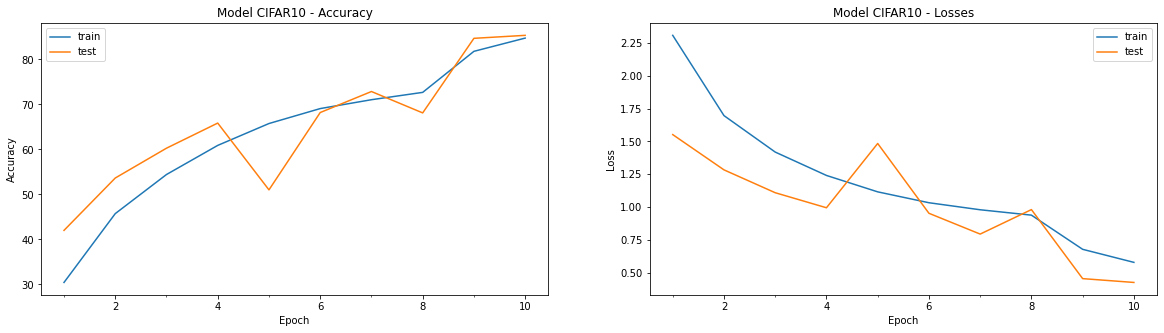

In [23]:
print("\nPloting Accuracy and Loss history: {}\n".format(model_name))
putils.plot_model_history(model_name, 
                   train_acc,test_acc,
                   train_losses,test_losses,
                   save_filename = "model_history")

# Misclassified images


Ploting misclassified images: Model CIFAR10



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

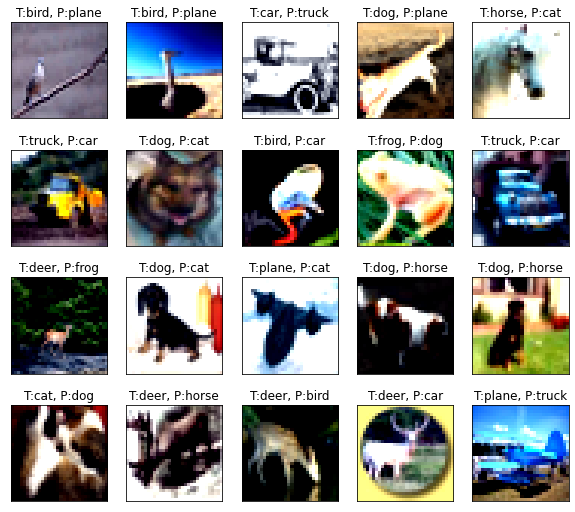

In [25]:
print ("\nPloting misclassified images: {}\n".format(model_name))

putils.miss_classification('Test',model, 
                          device, 
                          classes,
                          testloader=test_loader,
                          num_of_images = 20,
                          save_filename="model_misclassified")